In [1]:
#!/usr/bin/env python
# coding: utf-8
#
########################################
#      cluster Gaussian surrogate      #
########################################
#Author: Hengrui Luo
#hrluo@lbl.gov
#Last update: 2021-Jan-13
#
########################################
#          System information          #
########################################
#Print the python version and the name/input arguments
#%pylab inline
import sys
print('Clean everything.')
sys.modules[__name__].__dict__.clear()
import sys
print("Python version: ", sys.version)
print("This is the name of the script: ", sys.argv[0])
print(sys.argv)

#Print the numpy version and set the random seed
import numpy as np
print('numpy version: ', np.__version__)
RND_SEED=123
np.random.seed(RND_SEED)

#Random string
#Get a random string stamp for this specific run, used for the filename of image export.
import random
import string
def get_random_string(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))
rdstr=get_random_string(8)
print('random stamp for this run:',rdstr)

#Print the matplotlib version
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib version: ', matplotlib.__version__)

#Print the GPy version
import GPy
print('GPy version: ', GPy.__version__)

#Print the GPy version
import sklearn
print('sklearn version: ', sklearn.__version__)
from sklearn.gaussian_process import GaussianProcessRegressor

#######################################
#         Model specification          #
########################################
#How many pilot and sequential samples do we allow to get?
#N_PILOT is the pilot samples we start with, usually a small number would do.
#N_SEQUENTIAL is the number of sequential (noisy) samples we should draw from the black-box function.
N_PILOT = 10     #int(sys.argv[1])
N_SEQUENTIAL =  90#int(sys.argv[2])
#Which method should we use for the Bayesian optimization scheme?
#'FREQUENTIST' method means that the (hyper-)parameters are estimated by using some frequestist optimization like lbfgs.
#'BAYESIAN' method means that the paramteres are estimated by putting a prior(Gamma)-posterior mechnism, the estimated value would be posterior mean.
METHOD  = 'FREQUENTIST'
#Following 3 parameters are only for HMC Bayesian sampling, you have to choose METHOD  = 'BAYESIAN' to use these parameters.
N_BURNIN = 500
N_MCMCSAMPLES = 500
N_INFERENCE = 300
#Exploration rate is the probability (between 0 and 1) of following the next step produced by acquisition function.
EXPLORATION_RATE = 1.0
#Do you want a cluster GP? If NO_CLUSTER = True, a simple GP will be used.
NO_CLUSTER = False

#Do you want to amplify the weight/role of response X when doing clustering?
X_AMPLIFY = 0#/4096
#Do you want to subtract an amount from the response X when doing clustering?
X_TRANSLATE = []
#Do you want to amplify the weight/role of response Y when doing clustering?
Y_AMPLIFY = 0.5#/1000
#Do you want to subtract an amount from the response Y when doing clustering?
Y_TRANSLATE = 0.
#What is the maximal number of cluster by your guess? This option will be used only if NO_CLUSTER=False.
N_COMPONENTS = 3
#When deciding cluster components, how many neighbors shall we look into and get their votes? This option will be used only if NO_CLUSTER=False.
N_NEIGHBORS = 1
#Amount of NUGGET in the GP surrogate that stabilize the GP model, especially in FREQUENTIST approach.
#NUGGET = 1e-4(Deprecated since ver 0.7, we can use a white kernel to estimate this)
#How many time shall we jitter the diagonal of the covariance matrix when we encounter numerical non-positive definiteness in Gaussian process surrogate fitting.
#This is a GPy parameter, default is 5 in GPy.
N_JITTER = 6
#Overriding GPy default jitter, dangerous jittering
GPy.util.linalg.jitchol.__defaults__ = (N_JITTER,)
print(GPy.util.linalg.jitchol.__defaults__)
#This is a GPy parameter, whether you want to normalize the response before/after fitting. Don't change unless necessary.
GPy_normalizer = True
#Whether we should sample repetitive locations in the sequential sampling procedure.
#If True, we would keep identical sequential samples no matter what. (Preferred if we believe a lot of noise)
#If False, we would re-sample when we run into identical sequential samples. (Default)
#In a acquisition maximization step, this is achieved by setting the acquisition function at repetitive samples to -Inf
#In a random search step, this is achieved by repeat the random selection until we got a new location.
REPEAT_SAMPLE = False
#ver 0.7 new, we can use sklearn GP regression implementation.
USE_SKLEARN = True
ALPHA_SKLEARN = 1e-5
#Value added to the diagonal of the kernel matrix during fitting. 
SKLEARN_normalizer = True

Clean everything.
Python version:  3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
This is the name of the script:  /home/hrluo/.local/lib/python3.10/site-packages/ipykernel_launcher.py
['/home/hrluo/.local/lib/python3.10/site-packages/ipykernel_launcher.py', '--f=/home/hrluo/.local/share/jupyter/runtime/kernel-v2-244681AXUPhCV4ncsV.json']
numpy version:  1.23.5
random stamp for this run: pmwzjciz
matplotlib version:  3.3.3
GPy version:  1.10.0
sklearn version:  1.1.0
(6,)


In [2]:
##################################################
#   Example 4: record dataset mapping, matmul    #
##################################################
EXAMPLE_NAME='hypre2d_dimmerge'
#This loads the dataset for building a black-box function
#The format of the dataset should be a csv file, the first column being the response (Y)
#The rest columns of the dataset is the d-dimensional inputs (X)
#
from numpy import genfromtxt
my_data = genfromtxt('hypre2d_dimmerge_grid_data.csv', delimiter=',')
print(my_data.shape)
my_data = np.delete(my_data, (0), axis=0)
my_data = np.delete(my_data, (-1), axis=0)
Y_obs = my_data[:,1].astype(float).reshape(-1,1)
X_obs = my_data[:,0].astype(float).reshape(-1,1)
#Dimension of the input domain
#d = X_obs.shape[1]
print(X_obs.shape)
print(Y_obs.shape)
print(X_obs)
print(Y_obs)
########################################
#          Function wrapping           #
########################################
#This allows us to wrap a real-world dataset into the format of a black-box function useful 
#Given a point X, we find the closest point X' in the dataset (by some distance measure, currently L^2).
#The black-box function would return the observed response value Y' for X'. 
#This wrapping would makes the black-box function to be piece-wise constant. 
#
from scipy.spatial.distance import cdist
def f_truth(X):
    to_obs = cdist(X,X_obs, metric='euclidean')
    closest_obs = np.argmin(to_obs)
    ret_X = X_obs[closest_obs,:]
    ret_Y = Y_obs[closest_obs,:]
    #ret_X = int(X)
    #print(np.argwhere(ret_X==X_obs))
    #ret_Y = Y_obs[np.argwhere(ret_X==X_obs)[0,0],:]
    ret_Y = Y_obs[np.argmin(np.abs(ret_X-X_obs) ),:]
    print('Closest point in dataset is ',ret_X,' with observed value ',ret_Y[0])
    return ret_Y[0].astype(float)
point1 = np.ones((1,1))*0.55254444#*240.0
print(f_truth(point1))
bounds = np.array([[0.,4.]]).astype(float)
#print(bounds)

(4002, 2)
(4000, 1)
(4000, 1)
[[0.000e+00]
 [1.000e-03]
 [2.000e-03]
 ...
 [3.997e+00]
 [3.998e+00]
 [3.999e+00]]
[[0.081028]
 [0.085594]
 [0.080507]
 ...
 [0.113814]
 [0.124894]
 [0.126991]]
Closest point in dataset is  [0.553]  with observed value  0.086567
0.086567


In [3]:
N_GRID = 1024
x_p = [None]*bounds.shape[0]
for i in range(bounds.shape[0]):
    x_p[i] = np.linspace(start=bounds[i,0], stop=bounds[i,1], num=N_GRID)
    x0grid_ravel = np.vstack(np.meshgrid( *x_p )).reshape(bounds.shape[0],-1).T
    x0grid_ravel = np.arange(0,4,0.001)
    x0grid_ravel = x0grid_ravel.astype(float).reshape(-1,1)
#You must supply a parameter called 'bounds'.
inp_dim=bounds.shape[0]

#Which kernel you want to use for your model? Such a kernel must be implemented as a GPy/sklearn kernel class.
if USE_SKLEARN==True:
    from sklearn.gaussian_process import *
    KERNEL_TEMPLATE = sklearn.gaussian_process.kernels.Matern(length_scale=np.ones(inp_dim,), length_scale_bounds=(1e-05, 100000.0), nu=3/2) + sklearn.gaussian_process.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-03, 1000.0))
    #KERNEL_TEMPLATE = sklearn.gaussian_process.kernels.Matern(length_scale=np.ones(inp_dim,), length_scale_bounds=(1e-05, 100000.0), nu=1/2)
else:
    KERNEL_TEMPLATE = GPy.kern.Matern32(input_dim=inp_dim, variance=1., lengthscale=1.) + GPy.kern.White(input_dim=inp_dim)
    #KERNEL_TEMPLATE = GPy.kern.Exponential(input_dim=inp_dim, variance=1., lengthscale=1.)
#Do you want to penalize boundary sample points? If so, how?
def boundary_penalty(X,data_X=None):
    #return 0
    #return np.zeros((X.shape[0],1)) #if you don't want any penalty, use this line as the definition of your penalty
    #ret = []
    #for g in range(X.shape[0]):
    #    g_list = []
    #    for h in range(bounds.shape[1]):
    #        g_list.append( np.sum( (X[g,:]-bounds[:,h])**2 ) )
    #    ret.append(min(g_list))
    #res = X.astype(int)%8==0
    #return res*(100)\
    #if X<100:
    #    return -1e5
    if X.astype(int)%8==0:
        return 0
    else:
        return -1e3
    return -1e3
def censor_function(Y):
    #return Y #if you don't want any censor, use this line as the definition of your censor function.
    ret = Y
    #ret = Y.*(Y<20000 & Y>100)
    return ret#-np.minimum(0.1,10/np.asarray(ret))
#ver 0.6 new, 
#if random_domain returns TRUE, then such a choice by the random step is acceptable.
#if random_domain returns FALSE, then such a choice is out of our search input domain, and we would like to re-sample another random location.
def random_domain(X,data_X=None):
    return True
    #for i in range(data_X.shape[0]):
    #    if all(X.astype(int)== data_X[i,:].astype(int)) and ~REPEAT_SAMPLE: return False
    #    #This is only for matmul example searching only multiples of 8.
    #return X.astype(int)%8==0 

In [4]:
from datetime import datetime
# datetime object containing current date and time
samplestartingtime = datetime.now()
########################################
#          Draw pilot samples          #
########################################
#This cell only provides a pilot sample.
#Prepare pilot samples (X,Y)
print('\n>>>>>>>>>>Sampling ',N_PILOT,' pilot samples...<<<<<<<<<<\n')
print('Example : ',EXAMPLE_NAME)
X_sample = np.zeros((N_PILOT,bounds.shape[0]))
Y_sample = np.zeros((N_PILOT,1))
for j in range(bounds.shape[0]):
    X_sample[:,j] = np.random.uniform(bounds[j,0],bounds[j,1],size=(N_PILOT,1)).ravel()
Y_sample = np.zeros((N_PILOT,1))
for k in range(N_PILOT):
    Y_sample[k,0] = f_truth(X_sample[k,:].reshape(1,-1))
    Y_sample[k,0] = censor_function(Y_sample[k,0])
#print('Pilot X',X_sample)
#print('Pilot Y',Y_sample)

from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KNeighborsClassifier
#The cGP procedure consists of following steps
#Step 1. For observations, we can do a (unsupervised) (X,Y)-clustering and label them, different components are generated.
#Step 2. For predictive locations, we can do a (supervised) k-nearest neighbor classification, and predict at each location based on which component it belongs to. 
#Step 3. We compute the acquisition function and then proceed to the next sample, after adding the new sample we repeat Step 1 and 2.

#Prepare an up-to-date X_TRANSLATE, as the empirical mean of the X_sample
if len(X_TRANSLATE)>0:
    X_TRANSLATE = np.mean(X_sample,axis=0)
#Prepare an up-to-date Y_TRANSLATE, as the empirical mean of the Y_sample
if Y_TRANSLATE != 0:
    Y_TRANSLATE = np.mean(Y_sample)
#print(Y_sample - Y_TRANSLATE)
#Prepare initial clusters, with XY-joint.
XY_sample       = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
#dgm_XY = BayesianGaussianMixture(
#                    #weight_concentration_prior_type="dirichlet_distribution",
#                    weight_concentration_prior_type="dirichlet_process",
#                    n_components=N_COMPONENTS,#pick a big number, DGM will automatically adjust
#                    )
dgm_XY = KMeans(n_clusters=N_COMPONENTS, random_state=0)
XY_label = dgm_XY.fit_predict(XY_sample)
print('\n Initial labels for (X,Y)-joint clustering',XY_label)
#Make copies of X_sample for X-only fitting and XY-joint fitting.
X_sample_XY = np.copy(X_sample)
Y_sample_XY = np.copy(Y_sample)
#Prepare initial labels
clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
clf_XY.fit(X_sample_XY, XY_label)
#This is an artifact, we need to have at least d samples to fit a d-dimensional GP model (for its mean and variance)
for c in np.unique(XY_label):
    if sum(XY_label==c)<=X_sample_XY.shape[1]:
        occ = np.bincount(XY_label)
        XY_label[np.where(XY_label==c)] = np.argmax(occ)

        
print(X_sample,Y_sample)
print(XY_sample)


>>>>>>>>>>Sampling  10  pilot samples...<<<<<<<<<<

Example :  hypre2d_dimmerge
Closest point in dataset is  [2.786]  with observed value  0.09018799999999999
Closest point in dataset is  [1.145]  with observed value  0.08108
Closest point in dataset is  [0.907]  with observed value  0.066852
Closest point in dataset is  [2.205]  with observed value  0.090636
Closest point in dataset is  [2.878]  with observed value  0.08704200000000001
Closest point in dataset is  [1.692]  with observed value  0.081977
Closest point in dataset is  [3.923]  with observed value  0.07882
Closest point in dataset is  [2.739]  with observed value  0.08804899999999999
Closest point in dataset is  [1.924]  with observed value  0.091949
Closest point in dataset is  [1.568]  with observed value  0.08383199999999999

 Initial labels for (X,Y)-joint clustering [1 0 2 1 1 0 0 1 1 0]
[[2.78587674]
 [1.14455734]
 [0.90740581]
 [2.20525908]
 [2.87787588]
 [1.69242584]
 [3.92305679]
 [2.73931895]
 [1.92372761]
 [1.5

In [5]:
########################################
#        Draw sequential samples       #
########################################
from scipy import stats
from matplotlib import cm
mycm = cm.Spectral
VERBOSE = False
GETPLOT = False

#Prepare sequential samples (X,Y)
print('\n>>>>>>>>>>Sampling ',N_SEQUENTIAL,' sequential samples...<<<<<<<<<<\n')
X_sample = X_sample_XY
Y_sample = Y_sample_XY
cluster_label = XY_label

def get_KER():
    return KERNEL_TEMPLATE
#This recode function will turn the labels into increasing order,e.g. [1, 1, 3, 3, 0] ==> [0, 0, 1, 1, 2].
def recode(label):
    level = np.unique(np.array(label))
    ck = 0
    for j in level:
        label[label==j]=ck
        ck=ck+1
    return label
#Main loop that guides us in sampling sequential samples
comp_l = np.unique(np.array(cluster_label))

for it in range(N_SEQUENTIAL):
    print('\n>>>>>>>>>> ***** STEP ',it+1,'/',N_SEQUENTIAL,'***** <<<<<<<<<<')
    #Step 1. For observations, we can do a (unsupervised) (X,Y)-clustering and label them, different components are generated.
    #Create the (X,Y) joint sample to conduct (unsupervised clustering)
    if len(X_TRANSLATE)>0:
        X_TRANSLATE = np.mean(X_sample,axis=0)
    if Y_TRANSLATE != 0:
        Y_TRANSLATE = np.mean(Y_sample)
    #The cluster must be based on adjusted response value Y.
    XY_sample        = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
    if NO_CLUSTER:
        print('>>NO CLUSTER, a GP surrogate.')
        cluster_label    = np.zeros(XY_sample.shape[0])
    else:
        print('>>CLUSTERED, a cGP surrogate.',len(comp_l),' components in surrogate model.')
        cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
        if VERBOSE: print('dgm label', cluster_label)
        #Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
        for c in np.unique(cluster_label):
            if sum(cluster_label==c)<=X_sample.shape[1]:
                occ = np.bincount(cluster_label)
                cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
        if VERBOSE: print('merged label',cluster_label)
    cluster_label = recode(cluster_label)
    if VERBOSE: print('All labels are recoded: ',cluster_label)
    #Create arrays to store the mean&variance at observed locations and predictive locations.
    n_component=len(np.unique(cluster_label))
    mean_fun = np.zeros((len(cluster_label),1))
    var_fun = np.copy(mean_fun)
    
    #Step 2. For predictive locations, we can do a (supervised) k-nearest neighbor classification, and predict at each location based on which component it belongs to. 
    clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
    clf_XY.fit(X_sample,cluster_label)
        
    #Step 3. We either randomly search one location or compute the acquisition function and then proceed to the next sample, after adding the new sample we repeat Step 1 and 2.
    coin = np.random.uniform(0,1,1)
    if coin<EXPLORATION_RATE:
        print('>>>>Find next sample: acquisition proposal.')
        comp_l = np.unique(np.array(cluster_label))
        for c in comp_l:
            #Assign the corresponding X_sample and Y_sample values to the cluster coded by c. 
            c_idx = np.where(cluster_label == int(c))
            if VERBOSE: 
                print('>>>>Fitting component ',c,'/',len(comp_l)-1,' total components')
                print(c_idx)
            Xt = X_sample[c_idx].ravel().reshape(-1,X_sample.shape[1])
            Yt = Y_sample[c_idx].ravel().reshape(-1,1)
            #Fit the model with normalization
            if USE_SKLEARN==True:
                mt = GaussianProcessRegressor(kernel=get_KER(), random_state=0, normalize_y=SKLEARN_normalizer,alpha=ALPHA_SKLEARN,  
                                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=int(10*bounds.shape[0]))
            else:
                mt = GPy.models.GPRegression(Xt, Yt, kernel=get_KER(), normalizer=GPy_normalizer)
            ###
            if METHOD == 'FREQUENTIST':
                ##############################
                #Frequentist MLE GP surrogate#
                ##############################
                print('>>>>>>METHOD: frequentist MLE approach, component '+str(c)+'/'+str(len(comp_l)-1))
                print('>>>>>>SAMPLE: component sample size =',len(c_idx[0]) )
                if USE_SKLEARN==True:
                    mt.fit(Xt, Yt)
                    #No need to do more for sklearn GP
                    print('>>>>>>MODULE: sklearn is used, l-bfgs optimization.')
                    if VERBOSE: print(mt.kernel_, mt.log_marginal_likelihood(mt.kernel_.theta))
                else:
                    print('>>>>>>MODULE: GPy is used, l-bfgs optimization.')
                    mt.optimize(optimizer='bfgs', gtol = 1e-100, messages=VERBOSE, max_iters=int(10000*bounds.shape[0]))
                    mt.optimize_restarts(num_restarts=int(10*bounds.shape[0]),robust=True,verbose=VERBOSE)
            elif METHOD == 'BAYESIAN':
                if USE_SKLEARN: sys.exit('FUTURE: Currently we cannot fit with Bayesian method using sklearn, we have GPy only.')
                ##############################
                #Fully Bayesian GP surrogate #
                ##############################
                #Prior on the "hyper-parameters" for the GP surrogate model.
                print('>>>>>>METHOD: Fully Bayesian approach, component '+str(c)+'/'+str(len(comp_l)-1))
                print('>>>>>>SAMPLE: component sample size =',len(c_idx[0]) )
                mt.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
                mt.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
                #HMC sampling, fully Bayesian approach to estimate the kernel parameters.
                hmc = GPy.inference.mcmc.HMC(mt,stepsize=0.1)
                s = hmc.sample(num_samples=N_BURNIN) # Burnin
                s = hmc.sample(num_samples=N_MCMCSAMPLES)
                MCMC_samples = s[N_INFERENCE:] # cut out the burn-in period
                # Set the model parameters as the posterior mean
                mt.kern.variance[:]    = MCMC_samples[:,0].mean()
                mt.kern.lengthscale[:] = MCMC_samples[:,1].mean()
            #######################################
            # Optimization module(each component) #
            #######################################
            #mt2 predicts on observed locations.
            #No matter GRID_SEARCH true or not, we still need to predict on observed locations
            if USE_SKLEARN:
                mt2 = mt.predict(Xt,return_std=True, return_cov=False)
                mean_fun[c_idx,0] = mean_fun[c_idx,0] + mt2[0].reshape(1,-1)
                var_fun[c_idx,0]  = var_fun[c_idx,0]  + mt2[1].reshape(1,-1)
            else:
                mt2 = mt.predict(Xt)
                mean_fun[c_idx,0] = mean_fun[c_idx,0] + mt2[0].reshape(1,-1)#*np.std(Yt) + np.mean(Yt)
                var_fun[c_idx,0]  = var_fun[c_idx,0]  + mt2[1].reshape(1,-1)#*np.std(Yt)*np.std(Yt)
            #Define the expected improvement as objective function to optimize over.
            def my_obj(X):
                my_X = X.reshape(1, -1)
                my_X_label = clf_XY.predict(my_X)
                #If not in this component, set it to zero immediately.
                if my_X_label != int(c): return -0
                my_xi = 0.0 #tuning parameter, set it to zero for now.
                if USE_SKLEARN:
                    my_gp = mt.predict(my_X, return_std=True, return_cov=False)
                    my_mu = my_gp[0]
                    my_sigma = my_gp[1]
                else:
                    my_gp = mt.predict(my_X)
                    my_mu = my_gp[0]
                    my_sigma = my_gp[1]
                    my_sigma = np.sqrt(np.absolute(my_sigma)).reshape(-1, 1)
                my_mu = np.asarray(my_mu)
                my_sigma = np.asarray(my_sigma)
                with np.errstate(divide='warn'):
                    my_imp = my_mu - np.max(mt2[0].reshape(1,-1)) - my_xi
                    my_Z = np.divide(my_imp,my_sigma)
                    #norm = mvn(mean=np.zeros(X_sample[0,:].shape), cov=np.eye(X_sample.shape[1]))
                    my_ei = my_imp * norm.cdf(my_Z) + my_sigma * norm.pdf(my_Z)
                    my_ei[np.where(my_sigma <= 0.0)] = 0.0
                #Here we penalize the acquisition function value according to boundary_penalty function, by default this would be disabled. See document for details.
                my_ei = my_ei + boundary_penalty(my_X,X_sample)
                my_ei = float(my_ei.ravel())
                if VERBOSE: print('EI=',my_ei,'\n')
                return - my_ei/Xt.shape[0]
            #Optimize this my_obj using some optimization method.
            from scipy.optimize import minimize
            #from scipy.optimize import dual_annealing
            func = my_obj#lambda x:my_obj(x,mt,clf_XY) #Since the anneal finds minimum
            lw = bounds[:,0].tolist()
            up = bounds[:,1].tolist()
            #ret = dual_annealing(func, bounds=list(zip(lw, up)), seed=123)
            #dual annealing works for dim=1
            ret = minimize(fun=func, x0=np.random.uniform(bounds[:,0].T,bounds[:,1].T), bounds=list(zip(lw, up)), method='L-BFGS-B')
            print('>>>>Maximal acquisition function = ',-ret.fun,' attained at ',ret.x,' for component ',c)
            X_next = ret.x
    else:
        print('>>>>Find next sample: random search.')
        randomize_counter = 0
        X_rand = np.zeros((1,bounds.shape[0]))
        for j in range(bounds.shape[0]):
            X_rand[0,j] = np.random.uniform(bounds[j,0],bounds[j,1],1)
        X_next = X_rand
        #If we do not want repetitive samples, we sample until there are no points nearby. 
        while ~random_domain(X_next,X_sample):
            if VERBOSE: print('Random search: ',X_next,'hits a repetitive sample OR does not hit the random_domain constraint, resampling...')
            X_rand = np.zeros((1,bounds.shape[0]))
            for j in range(bounds.shape[0]):
                X_rand[0,j] = np.random.uniform(bounds[j,0],bounds[j,1],1)
            X_next = X_rand
            randomize_counter = randomize_counter + 1
        print('>>>>Random search stops after ',randomize_counter,' steps.')
    #Optional: Following are plotting features that tracks the optimization procedure
    X_next = X_next.reshape(1,-1)
    Y_next = f_truth(X_next)
    print('----------')
    print('>>Next sample input is chosen to be: ',X_next)
    print('>>Next sample response is chosen to be: ',Y_next.ravel())
    if GETPLOT:
        X_new = x0grid_ravel
        if bounds.shape[0]==1:
            fig, axs = plt.subplots(2,figsize=(6,6))
            fig.suptitle('Fitted surrogate model, sample size = '+str(X_sample.shape[0]))
            axs[0].plot(X_new,mean_new,color='b')
            axs[0].scatter(X_sample,Y_sample,color='b')
            axs[0].set_title('observed samples and mean')
            ci = np.sqrt(var_new)#/mean_new
            axs[0].fill_between(X_new.ravel(), (mean_new-ci).ravel(), (mean_new+ci).ravel(), color='b', alpha=.1)
            axs[1].plot(fine_grid,ei_grid,color='k')
            axs[1].scatter(X_next,ei_next,marker='v',color='r',s=100)
            axs[1].text(s='x='+str(X_next),x=X_next,y=np.max(ei_grid),color='r',fontsize=12)
            axs[1].set_title('acquisition/expected improvement function')
            plt.show()
        if bounds.shape[0]==2:
            fig, axs = plt.subplots(2,figsize=(6,12))
            fig.suptitle('Fitted surrogate model, sample size = '+str(X_sample.shape[0]))
            axs[0].scatter(X_new[:,0],X_new[:,1],c=mean_new.ravel(),cmap=mycm)
            axs[0].scatter(X_sample[:,0],X_sample[:,1],c=Y_sample.ravel(),cmap=mycm,marker='v',s=200,edgecolors='k')

            axs[0].set_title('observed samples and mean')
            ci = np.sqrt(var_new)#/mean_new
            axs[1].scatter(fine_grid[:,0],fine_grid[:,1],c=ei_grid.ravel(),cmap=mycm)
            axs[1].scatter(X_next[0,0],X_next[0,1],marker='v',color=None,s=200,edgecolors='k')
            axs[1].text(s='x='+str(X_next),x=X_next[0,0],y=X_next[0,1],color='k',fontsize=12)
            axs[1].set_title('acquisition/expected improvement function')
            plt.show()
        #plt.savefig('cGP'+rdstr+'_step'+str(it)+'_'+str(n)+'_'+str(m)+'_'+str(l)+'.png')
    #Update X and Y from this step.
    X_sample = np.vstack((X_sample,X_next))
    Y_sample = np.vstack((Y_sample,censor_function(Y_next) ))




>>>>>>>>>>Sampling  90  sequential samples...<<<<<<<<<<


>>>>>>>>>> ***** STEP  1 / 90 ***** <<<<<<<<<<
>>CLUSTERED, a cGP surrogate. 2  components in surrogate model.


>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0/1
>>>>>>SAMPLE: component sample size = 4
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  0  attained at  [2.91619883]  for component  0
>>>>>>METHOD: frequentist MLE approach, component 1/1
>>>>>>SAMPLE: component sample size = 6
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  0  attained at  [1.75428898]  for component  1
Closest point in dataset is  [1.754]  with observed value  0.090103
----------
>>Next sample input is chosen to be:  [[1.75428898]]
>>Next sample response is chosen to be:  [0.090103]

>>>>>>>>>> ***** STEP  2 / 90 ***** <<<<<<<<<<
>>CLUSTERED, a cGP surrogate. 2  components in surrogate model.
>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0/1
>>>>>>SAMPLE: component sample size = 4
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal 

 /home/hrluo/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
 /home/hrluo/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.


>>>>Maximal acquisition function =  -142.85713811159476  attained at  [2.95205552]  for component  1
Closest point in dataset is  [2.952]  with observed value  0.088775
----------
>>Next sample input is chosen to be:  [[2.95205552]]
>>Next sample response is chosen to be:  [0.088775]

>>>>>>>>>> ***** STEP  3 / 90 ***** <<<<<<<<<<
>>CLUSTERED, a cGP surrogate. 2  components in surrogate model.
>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0/1
>>>>>>SAMPLE: component sample size = 4
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  0  attained at  [0.70180702]  for component  0
>>>>>>METHOD: frequentist MLE approach, component 1/1
>>>>>>SAMPLE: component sample size = 8
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  -124.99992635999327  attained at  [2.12584028]  for component  1
Closest point in dataset is  [2.126]  with observed value  0.090657
----------
>>Ne

In [ ]:
sampleendingtime = datetime.now()
# dd/mm/YY H:M:S
samplestartingtime  = samplestartingtime.strftime("%Y/%m/%d %H:%M:%S")
sampleendingtime  = sampleendingtime.strftime("%Y/%m/%d %H:%M:%S")
print("Sample start date and time =", samplestartingtime)
print("Sample end date and time =", sampleendingtime)
#print(X_sample)
#print(Y_sample)
#print(np.hstack((Y_sample,X_sample)).shape)
if NO_CLUSTER==True:
    FILE_NAME = EXAMPLE_NAME+'_local_GP('+rdstr+')'
else:
    FILE_NAME = EXAMPLE_NAME+'_local_cGP_k='+str(N_COMPONENTS)+'('+rdstr+')'
np.savetxt(FILE_NAME+'.txt', np.hstack((Y_sample,X_sample)), delimiter =', ')  

sample_max_x = X_sample[np.argmax(Y_sample),:] 
sample_max_f = np.round( Y_sample[np.argmax(Y_sample),:],3)
sample_min_x = X_sample[np.argmin(Y_sample),:] 
sample_min_f = np.round( Y_sample[np.argmin(Y_sample),:],3)

Sample start date and time = 2024/02/25 00:43:47
Sample end date and time = 2024/02/25 00:44:01


In [ ]:
if True:
    original_stdout = sys.stdout # Save a reference to the original standard output
    with open(FILE_NAME+'.log', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        #print('This message will be written to a file.')
        print("Example: ",EXAMPLE_NAME,file=f)
        print("Sample start date and time = ", samplestartingtime)
        print("Sample end date and time = ", sampleendingtime)
        print("Python version: ", sys.version)
        #print("Filename of the script: ", sys.argv[0])
        print("Commandline arguments: ",sys.argv)
        print("Random seed: ",RND_SEED)
        print('Random stamp: ',rdstr)
        print('GPy version: ', GPy.__version__)
        print('sklearn version: ', sklearn.__version__)
        print('Number of pilot samples: ',N_PILOT)
        print('Number of sequential samples: ',N_SEQUENTIAL)
        print('Surrogate fitting method: ',METHOD)
        if METHOD=="BAYESIAN":
            print('MCMC>Burn-in steps: ',N_BURNIN)
            print('MCMC>Sampling steps: ',N_MCMCSAMPLES)
            print('MCMC>Inference sample length: ',N_INFERENCE)
        print('Surrogate> Are we using sklearn for GPR?: ',USE_SKLEARN)
        print('Surrogate> kernel type: ',get_KER())
        if USE_SKLEARN:
            print('Surrogate>sklearn>jittering: ',ALPHA_SKLEARN)
            print('Surrogate>sklearn>normalizer; ',SKLEARN_normalizer)
        else:
            #print('Surrogate>GPy>Nugget noise variance',NUGGET)
            print('Surrogate>GPy>jittering: ',N_JITTER)
            print('Surrogate>GPy>normalizer; ',GPy_normalizer)
        print('Surrogate> Fit a simple GP?(no cluster): ',NO_CLUSTER)
        print('Cluster> Response amplifier when clustering: ',Y_AMPLIFY)
        print('Cluster> Maximal number of components/clusters: ',N_COMPONENTS)
        print('Classify> k in k-nearest neighbor classifier',N_NEIGHBORS)
        print('Exploration rate: ',EXPLORATION_RATE)
        #print('Exploration> Do we perform grid-search in acquisition maximization?',GRID_SEARCH)
        print('Exploration> Do we allow repeat samples in random searching?',REPEAT_SAMPLE)
        print('domain bounds: ',bounds)
        #print('blur amount: ',blur_amount)
        print('sample minimum, f_min=',sample_min_f,' at ',sample_min_x)
        print('sample maximum, f_max=',sample_max_f,' at ',sample_max_x)
        print('>>Cluster X_AMPLIFY=',X_AMPLIFY)
        print('>>Cluster X_TRANSLATE=',X_TRANSLATE)
        print('>>Cluster Y_AMPLIFY=',Y_AMPLIFY)
        print('>>Cluster Y_TRANSLATE=',Y_TRANSLATE)
    sys.stdout = original_stdout # Reset the standard output to its original value

#%debug
import os
print('Logs of run with stamp: ',rdstr,', is saved at',os.getcwd())

Logs of run with stamp:  ocrxrwsg , is saved at /media/hrluo/WORK1/LBNLhrluo/minimalcGP


In [ ]:
cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
prediction_label = clf_XY.predict(x0grid_ravel)#XY_predlabel
print('dgm label', cluster_label)
#Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
for c in np.unique(cluster_label):
    if sum(cluster_label==c)<=X_sample.shape[1]:
        occ = np.bincount(cluster_label)
        cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
print('merged label',cluster_label)

dgm label [0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1
 2 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1]
merged label [0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1
 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1]


newl [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1

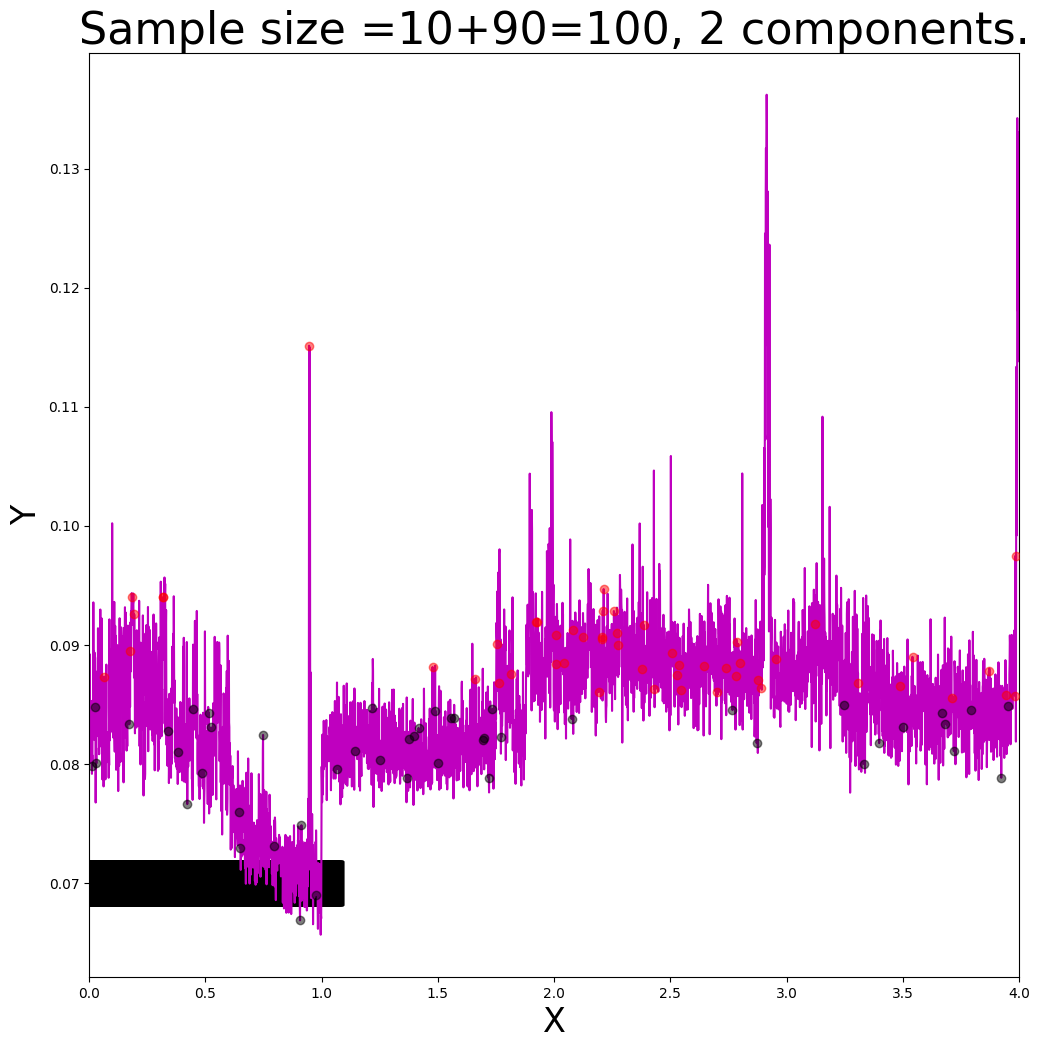

sample minimum, f_min= [0.067]  at  [0.90740581]
sample maximum, f_max= [0.115]  at  [0.94584958]
>>Cluster X_AMPLIFY= 0
>>Cluster X_TRANSLATE= []
>>Cluster Y_AMPLIFY= 0.5
>>Cluster Y_TRANSLATE= 0.0


In [ ]:
########################################
#      Plot the final model(1/2D)      #
########################################
import matplotlib.cm as cm
mycm = cm.coolwarm
X_new = x0grid_ravel#.squeeze()
fine_grid = x0grid_ravel
prediction_label = clf_XY.predict(x0grid_ravel)
new_label = clf_XY.predict(X_new)
print('newl',new_label)
col=['r','k','y','b','g'] #Generate a color scale, here usually there would not be more than 5 components.
mean_new = np.zeros((len(prediction_label),1))
var_new = np.copy(mean_new)
fig = plt.figure(figsize=(12,12))
#from IPython.display import display
if len(X_TRANSLATE)>0:
    X_TRANSLATE = np.mean(X_sample,axis=0)
if Y_TRANSLATE != 0:
    Y_TRANSLATE      = np.mean(Y_sample)
XY_sample        = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
#XY_sample        = np.concatenate((X_sample,Y_AMPLIFY*Y_sample.reshape(-1,1)),axis=1)
if NO_CLUSTER: 
    cluster_label    = np.zeros(XY_sample.shape[0])
    prediction_label = x0grid_ravel*0.
else:
    cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
    prediction_label = clf_XY.predict(x0grid_ravel)#XY_predlabel
    if VERBOSE: print('dgm label', cluster_label)
    #Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
    for c in np.unique(cluster_label):
        if sum(cluster_label==c)<=X_sample.shape[1]:
            occ = np.bincount(cluster_label)
            cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
    if VERBOSE: print('merged label',cluster_label)
cluster_label = recode(cluster_label)
clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
clf_XY.fit(X_sample,cluster_label)
#if GRID_SEARCH==True:
new_label = clf_XY.predict(X_new)
for c in np.unique(cluster_label):
            if sum(cluster_label==c)<=X_sample.shape[1]:
                occ = np.bincount(cluster_label)
                cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
cluster_label = recode(cluster_label)
print(cluster_label)
new_label = recode(new_label)
print(new_label)
for c in np.unique(np.array(cluster_label)):
        print('Fitting component ',c)
        c = int(c)
        #Assign the corresponding X_sample and Y_sample values to the cluster coded by c. 
        c_idx = np.where(cluster_label == int(c))
        if len(c_idx) <1: continue
        print(c_idx)
        Xt = X_sample[c_idx].ravel().reshape(-1,X_sample.shape[1])
        Yt = Y_sample[c_idx].ravel().reshape(-1,1)
        #print(Xt.shape,Yt.shape)
        #print(Xt,Yt)
        #Normalization
        #Fit the model
        if 'mt' in locals():
            del(mt)
            # mt exists.
        if USE_SKLEARN:
            mt = GaussianProcessRegressor(kernel=get_KER(), random_state=0, normalize_y=SKLEARN_normalizer, alpha=ALPHA_SKLEARN,  
                                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=int(10*bounds.shape[0]))
            mt.fit(Xt, Yt)
            print('Summary of component '+str(c)+' GP surrogate model.')
            print(mt.kernel_, mt.log_marginal_likelihood(mt.kernel_.theta))

        else:
            mt = GPy.models.GPRegression(Xt, Yt, kernel=get_KER(), normalizer=GPy_normalizer)
            mt.optimize(optimizer='bfgs', gtol = 10e-32, messages=False, max_iters=int(10000*bounds.shape[0]))
            mt.optimize_restarts(num_restarts=int(100*bounds.shape[0]),robust=True,verbose=False)
            #mt.plot()
            #plt.show()
            print('Summary of component '+str(c)+' GP surrogate model.')
            display(mt)
        c_idx_new = np.where(new_label == int(c))
        #c_idx_new = c_idx_new[0]
        if len(c_idx_new) <1: continue
        print(c_idx_new)
        #print(mean_new.shape)
        if USE_SKLEARN:
            mt1 = mt.predict(X_new[c_idx_new],return_std=True, return_cov=False)
            mt2 = mt.predict(fine_grid,return_std=True, return_cov=False)
            mu_new = mt1[0]
            sigma2_new = np.power(mt1[1],2)
        else:
            mt1 = mt.predict(X_new[c_idx_new])
            mt2 = mt.predict(fine_grid)
            mu_new = mt1[0]
            sigma2_new = mt1[1]
            
        mean_new[c_idx_new,0] = mean_new[c_idx_new,0] + mu_new.reshape(1,-1)
        var_new[c_idx_new,0]  = var_new[c_idx_new,0]  + sigma2_new.reshape(1,-1)
        
        if bounds.shape[0] == 1:
            print(c_idx_new)
            plt.scatter(X_new[c_idx_new],np.ones(X_new[c_idx_new].shape)*0.07,c=col[c],alpha=1,marker='s',s=1000)
            #plt.plot(fine_grid, mt2[0],color=col[c],linestyle='--',label='component '+str(c)+' mean')
            plt.scatter(X_sample[c_idx],   Y_sample[c_idx],label='sequential samples',c=col[c],alpha=0.5,zorder=99)
plt.plot(X_obs.squeeze(),Y_obs.squeeze(),c='m',zorder=1)
#plt.vlines(x=256, ymin=0, ymax=35000,color='g',linewidth=10,alpha=0.5)

if bounds.shape[0] == 1:
    print('1d plot')
    #plt.plot(X_new,mean_new,color='b',linewidth=4,alpha=0.5,label='overall mean')
    #plt.fill_between(X_new.ravel(), (mean_new-np.sqrt(var_new)).ravel(), (mean_new+np.sqrt(var_new)).ravel(), color='b', alpha=.1, label='overall std. deviation')
   
    #plt.vlines(x=sample_max_x, ymin=0, ymax=sample_max_f,color='b',linestyle='-.')
    #plt.text(s='sample max:'+str(sample_max_f[0])+'\n @'+str(sample_max_x),x=sample_max_x,y=100,c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_max_x[0]),x=sample_max_x,y=20,c='b',fontsize=12)

    ##plt.vlines(x=sample_min_x, ymin=0, ymax=sample_min_f,color='b',linestyle='-.')
    #plt.text(s='sample min:'+str(sample_min_f[0])+'\n @'+str(sample_min_x),x=sample_min_x,y=100,c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_min_x[0]),x=sample_min_x,y=10,c='b',fontsize=12)

    plt.title('Sample size ='+str(N_PILOT)+'+'+str(N_SEQUENTIAL)+'='+str(X_sample.shape[0])+', '+str(len(np.unique(np.array(cluster_label))))+' components.',fontsize=32)
    plt.ylabel('Y', fontsize=24)
    plt.xlabel('X', fontsize=24)
    plt.xlim((0,4))
    #plt.ylim((0.006,0.009))
    #plt.xticks(np.linspace(0, 4096, 9), fontsize=24)
    #plt.yticks(np.linspace(0, 35000, 6), fontsize=24)
    #plt.legend(fontsize=18,loc='lower center')
    
if bounds.shape[0] == 2:
    print('2d plot')
    plt.scatter(X_new[:,0],      X_new[:,1],      c=mean_new.ravel(),cmap=mycm,alpha=1.0,label='overall mean',marker='s',s=200,zorder=99)
    plt.scatter(X_sample[:,0],   X_sample[:,1],   c=Y_sample.ravel(),cmap=mycm,alpha=1.0,label='sequential samples',edgecolors='k',zorder=99)
    plt.scatter(X_sample_XY[:,0],X_sample_XY[:,1],c=Y_sample_XY.ravel(),cmap=mycm,alpha=1.0,label='pilot samples',marker='v',s=150,edgecolors='k',zorder=99)
    #plt.scatter(x=x_min[0], y=x_min[1], color='k')
    #plt.text(s='model min:'+str(f_min[0])+'\n @'+str(x_min),x=x_min[0],y=x_min[1],c='k',fontsize=12,rotation=45)

    #plt.scatter(x=x_max[0], y=x_max[1], color='k')
    #plt.text(s='model max:'+str(f_max[0])+'\n @'+str(x_max),x=x_max[0],y=x_max[1],c='k',fontsize=12,rotation=45)

    #plt.scatter(x=sample_max_x[0], y=sample_max_x[1], color='k')
    #plt.text(s='sample max:'+str(sample_max_f[0])+'\n @'+str(sample_max_x),x=sample_max_x[0],y=sample_max_x[1],c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_max_x[0]),x=sample_max_x,y=20,c='b',fontsize=12)

    #plt.scatter(x=sample_min_x[0], y=sample_min_x[1], color='k')
    #plt.text(s='sample min:'+str(sample_min_f[0])+'\n @'+str(sample_min_x),x=sample_min_x[0],y=sample_min_x[1],c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_min_x[0]),x=sample_min_x,y=10,c='b',fontsize=12)

    #plt.title('Sample size ='+str(X_sample.shape[0]),fontsize=24)
    plt.xlabel('X1', fontsize=24)
    plt.ylabel('X2', fontsize=24)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.xticks(np.linspace(-1, 1, 6), fontsize=24)
    plt.yticks(np.linspace(-1, 1, 6), fontsize=24)
    
    #plt.legend()

#plt.ylim((21000,31000))
#plt.yticks(ticks=[21000,23000,25000,27000,29000,31000])
plt.show()
fig.savefig(FILE_NAME+'.png', dpi=fig.dpi)
print('sample minimum, f_min=',sample_min_f,' at ',sample_min_x)
print('sample maximum, f_max=',sample_max_f,' at ',sample_max_x)
print('>>Cluster X_AMPLIFY=',X_AMPLIFY)
print('>>Cluster X_TRANSLATE=',X_TRANSLATE)
print('>>Cluster Y_AMPLIFY=',Y_AMPLIFY)
print('>>Cluster Y_TRANSLATE=',Y_TRANSLATE)

In [ ]:
print(X_new)

[[0.   ]
 [0.001]
 [0.002]
 [0.003]
 [0.004]
 [0.005]
 [0.006]
 [0.007]
 [0.008]
 [0.009]
 [0.01 ]
 [0.011]
 [0.012]
 [0.013]
 [0.014]
 [0.015]
 [0.016]
 [0.017]
 [0.018]
 [0.019]
 [0.02 ]
 [0.021]
 [0.022]
 [0.023]
 [0.024]
 [0.025]
 [0.026]
 [0.027]
 [0.028]
 [0.029]
 [0.03 ]
 [0.031]
 [0.032]
 [0.033]
 [0.034]
 [0.035]
 [0.036]
 [0.037]
 [0.038]
 [0.039]
 [0.04 ]
 [0.041]
 [0.042]
 [0.043]
 [0.044]
 [0.045]
 [0.046]
 [0.047]
 [0.048]
 [0.049]
 [0.05 ]
 [0.051]
 [0.052]
 [0.053]
 [0.054]
 [0.055]
 [0.056]
 [0.057]
 [0.058]
 [0.059]
 [0.06 ]
 [0.061]
 [0.062]
 [0.063]
 [0.064]
 [0.065]
 [0.066]
 [0.067]
 [0.068]
 [0.069]
 [0.07 ]
 [0.071]
 [0.072]
 [0.073]
 [0.074]
 [0.075]
 [0.076]
 [0.077]
 [0.078]
 [0.079]
 [0.08 ]
 [0.081]
 [0.082]
 [0.083]
 [0.084]
 [0.085]
 [0.086]
 [0.087]
 [0.088]
 [0.089]
 [0.09 ]
 [0.091]
 [0.092]
 [0.093]
 [0.094]
 [0.095]
 [0.096]
 [0.097]
 [0.098]
 [0.099]
 [0.1  ]
 [0.101]
 [0.102]
 [0.103]
 [0.104]
 [0.105]
 [0.106]
 [0.107]
 [0.108]
 [0.109]
 [0.11 ]
 

In [ ]:
print(np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1))
print(np.concatenate((X_sample,Y_AMPLIFY*(Y_sample-0.).reshape(-1,1)),axis=1))

[[0.045094 ]
 [0.04054  ]
 [0.033426 ]
 [0.045318 ]
 [0.043521 ]
 [0.0409885]
 [0.03941  ]
 [0.0440245]
 [0.0459745]
 [0.041916 ]
 [0.0450515]
 [0.0443875]
 [0.0453285]
 [0.0408675]
 [0.04317  ]
 [0.0374175]
 [0.0423045]
 [0.0401695]
 [0.044207 ]
 [0.0435705]
 [0.04287  ]
 [0.043389 ]
 [0.042334 ]
 [0.044251 ]
 [0.043013 ]
 [0.0344755]
 [0.0444935]
 [0.043975 ]
 [0.0436805]
 [0.041932 ]
 [0.0447425]
 [0.0428655]
 [0.0422545]
 [0.041038 ]
 [0.0415245]
 [0.0473365]
 [0.041504 ]
 [0.046435 ]
 [0.0424185]
 [0.045632 ]
 [0.046416 ]
 [0.037973 ]
 [0.04699  ]
 [0.043013 ]
 [0.044976 ]
 [0.046271 ]
 [0.0458835]
 [0.042295 ]
 [0.043381 ]
 [0.0413805]
 [0.042775 ]
 [0.04699  ]
 [0.042134 ]
 [0.0410865]
 [0.0424695]
 [0.045254 ]
 [0.0408695]
 [0.043085 ]
 [0.0395945]
 [0.048734 ]
 [0.0442215]
 [0.0418815]
 [0.0459745]
 [0.0412095]
 [0.0421385]
 [0.0454095]
 [0.0404935]
 [0.041656 ]
 [0.044644 ]
 [0.040036 ]
 [0.0393895]
 [0.0411125]
 [0.043888 ]
 [0.0397745]
 [0.057556 ]
 [0.0383065]
 [0.0441345]